In [1]:
#importing modules

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

import cv2

In [3]:
# reading dataset
imgs = np.load('images.npy')

In [69]:
labels = pd.read_csv('labels.csv')

In [4]:
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


In [5]:
# Gathering shape of data
labels.shape

(4750, 1)

In [6]:
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

In [7]:
imgs.shape

(4750, 128, 128, 3)

images are 128x128, 3 channels

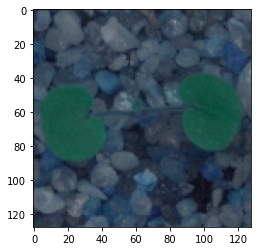

In [8]:
# Visualizing the images
plt.imshow(imgs[0])

## Data Preprocessing
### Gaussian Blurring

In [9]:
# Making a new list to hold new values after applying the blurring filter to the image
new_x = np.empty((4750, 128, 128, 3)) 

In [10]:
# Now apply gaussian blur to each image
for idx, img in enumerate(imgs):
  new_x[idx] = cv2.GaussianBlur(img, (5, 5), 0)

### Normalization

In [11]:
new_x = new_x.astype('float32')

In [12]:
new_x /= 255

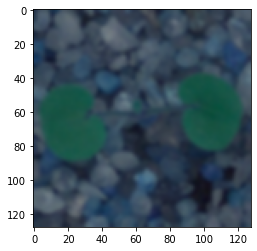

In [13]:
plt.imshow(new_x[0])

After preprocessing, the image is much blurrier than before

## Make data compatible

In [32]:
# More libraries
from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

In [36]:
# One hot encoding the variables
enc = LabelBinarizer()
y = enc.fit_transform(labels)
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [38]:
y.shape

(4750, 12)

In [39]:
from sklearn import svm
from sklearn.model_selection import train_test_split
#Split Train & Test
X_train,X_test_initial,y_train,y_test_initial=train_test_split(new_x,y,test_size=0.3,random_state=7)
#Split Data between test and validation
X_val,X_test,y_val,y_test=train_test_split(X_test_initial,y_test_initial,test_size=0.5)

In [40]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3325, 128, 128, 3)
(3325, 12)
(713, 128, 128, 3)
(713, 12)


In [41]:
print(y_train[0])

[0 0 0 1 0 0 0 0 0 0 0 0]


These shapes look compatible

## Building the CNN

In [42]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense

In [53]:
# Initialize the model
model = models.Sequential()
# Set the layers
# 2 convolutional layers
model.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(128, 128, 3)))
model.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
# Flatten the data
model.add(Flatten())
# 2 dense layers
model.add(Dense(128, activation="relu"))
# This layer must have neurons equal to output classes
model.add(Dense(12, activation="softmax"))

In [54]:
# Compile the model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Fit the model
model.fit( x=X_train, y=y_train, batch_size=32, epochs=10, validation_split = 0.3)

Epoch 1/10
73/73 [==============================] - 36s 487ms/step - loss: 2.8248 - accuracy: 0.3223 - val_loss: 1.3521 - val_accuracy: 0.5090
Epoch 2/10
73/73 [==============================] - 35s 484ms/step - loss: 1.2693 - accuracy: 0.5724 - val_loss: 1.1847 - val_accuracy: 0.5972
Epoch 3/10
73/73 [==============================] - 35s 479ms/step - loss: 0.9980 - accuracy: 0.6648 - val_loss: 1.1116 - val_accuracy: 0.6122
Epoch 4/10
73/73 [==============================] - 36s 488ms/step - loss: 0.7842 - accuracy: 0.7409 - val_loss: 1.2061 - val_accuracy: 0.6082
Epoch 5/10
73/73 [==============================] - 35s 483ms/step - loss: 0.6868 - accuracy: 0.7709 - val_loss: 1.1012 - val_accuracy: 0.6543
Epoch 6/10
73/73 [==============================] - 35s 485ms/step - loss: 0.4395 - accuracy: 0.8612 - val_loss: 1.2221 - val_accuracy: 0.6493
Epoch 7/10
73/73 [==============================] - 35s 481ms/step - loss: 0.2981 - accuracy: 0.9055 - val_loss: 1.3155 - val_accuracy: 0.6273

In [55]:
# Evaluate the test data
model.evaluate(X_test, y_test)

23/23 [==============================] - 1s 62ms/step - loss: 1.5810 - accuracy: 0.5989


[1.581017017364502, 0.5988779664039612]

In [56]:
#Evaluate the validation data
model.evaluate(X_val, y_val)

23/23 [==============================] - 1s 62ms/step - loss: 1.5051 - accuracy: 0.6236


[1.5051249265670776, 0.6235954761505127]

Validation data scored higher than the test data

In [47]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


In [60]:
# Making a confusion matrix with the validation data
digits_predictions = model.predict_classes(X_test, batch_size=128, verbose=0)
digits_labels=np.argmax(y_test, axis=1)

cm = confusion_matrix(digits_labels, digits_predictions)

C:\Users\Nick\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


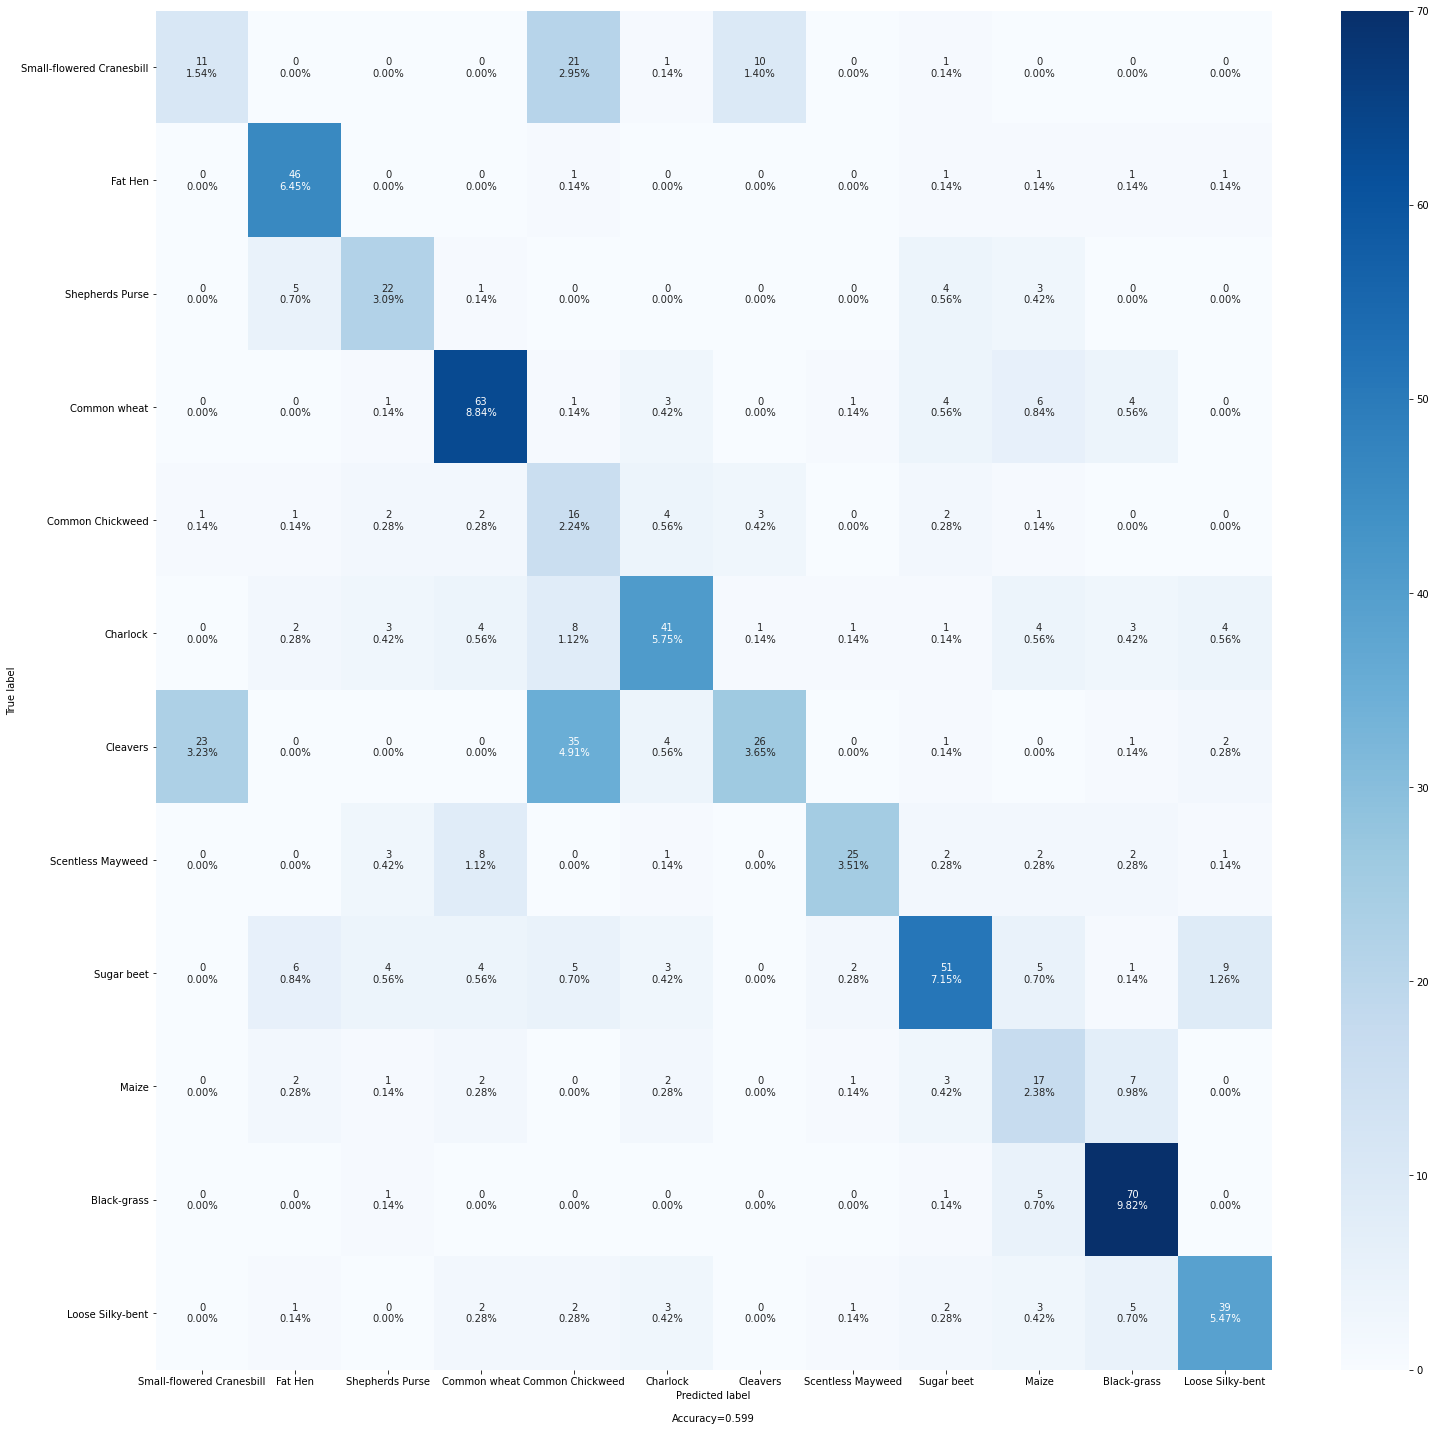

In [83]:
cm_labels = ['True Negative','False Positive','False Negative','True Positive']
categories = labels.Label.unique()
make_confusion_matrix(cm,
                      group_names=cm_labels,
                      categories=categories, 
                      cmap='Blues',
                     figsize=(25,25))

* This model finished with just under 60% accuracy
* 'Cleavers' and 'Small-flowered Cranesbill' were the most often identified as other plants, having been done so more often than they were identified correctly.
* 'Black Grass' was the most identified plant

## Visualizing some predictions

Predicted label: 4
Softmax Outputs: [[3.6318746e-01 4.4703032e-05 9.3294664e-05 8.9187148e-07 6.1641198e-01
  5.2293451e-03 1.3933365e-02 2.5981466e-05 6.1824376e-04 6.2760216e-07
  3.8653724e-07 4.5372848e-04]]
0.99999994


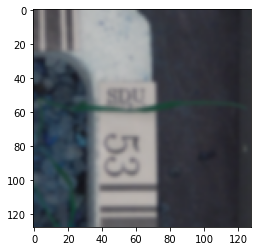

In [90]:
plt.imshow(X_test[2], cmap='gray')
y_pred = model.predict(X_test[2].reshape(1, 128, 128, 3))
print("Predicted label:", y_pred.argmax())
print("Softmax Outputs:", y_pred)
print(y_pred.sum())

Predicted label: 11
Softmax Outputs: [[7.9123978e-08 1.7940567e-04 1.0617212e-05 2.4856022e-04 1.2717024e-06
  2.8628867e-02 2.5321182e-04 8.7809658e-06 2.6262192e-05 1.9125404e-03
  1.2724602e-02 9.5600581e-01]]
1.0


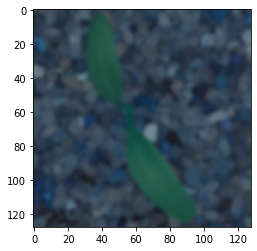

In [91]:
plt.imshow(X_test[3], cmap='gray')
y_pred = model.predict(X_test[3].reshape(1, 128, 128, 3))
print("Predicted label:", y_pred.argmax())
print("Softmax Outputs:", y_pred)
print(y_pred.sum())

Predicted label: 8
Softmax Outputs: [[2.8143808e-14 1.1733543e-02 1.1920606e-02 1.7474453e-05 2.2543240e-06
  1.5549178e-06 1.9310767e-13 2.3352591e-04 9.7576559e-01 1.0128373e-04
  2.9127074e-05 1.9505495e-04]]
1.0


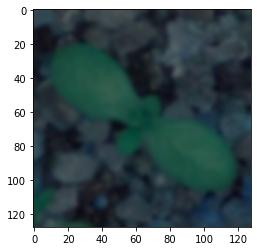

In [92]:
plt.imshow(X_test[33], cmap='gray')
y_pred = model.predict(X_test[33].reshape(1, 128, 128, 3))
print("Predicted label:", y_pred.argmax())
print("Softmax Outputs:", y_pred)
print(y_pred.sum())

Predicted label: 4
Softmax Outputs: [[8.5474469e-02 2.6885768e-06 1.2583802e-04 2.6485117e-07 7.6729089e-01
  5.5631075e-02 9.0789907e-02 5.2268701e-06 4.9852009e-04 1.2800308e-07
  4.3339174e-08 1.8092856e-04]]
1.0


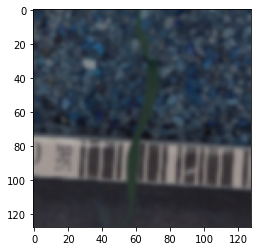

In [93]:
plt.imshow(X_test[36], cmap='gray')
y_pred = model.predict(X_test[36].reshape(1, 128, 128, 3))
print("Predicted label:", y_pred.argmax())
print("Softmax Outputs:", y_pred)
print(y_pred.sum())

Predicted label: 4
Softmax Outputs: [[9.8032057e-02 1.9685540e-05 2.5983452e-04 1.1634518e-06 5.6611508e-01
  3.7951570e-03 3.2917738e-01 3.6459573e-05 1.6802974e-03 1.2835483e-06
  1.6491659e-07 8.8144158e-04]]
1.0


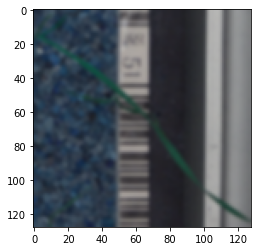

In [94]:
plt.imshow(X_test[59], cmap='gray')
y_pred = model.predict(X_test[59].reshape(1, 128, 128, 3))
print("Predicted label:", y_pred.argmax())
print("Softmax Outputs:", y_pred)
print(y_pred.sum())